H&M — High-performance threshold (Sales Q3): 204.57
high_performance
0    0.747475
1    0.252525
Name: Class proportion, dtype: float64

=== Random Forest — Holdout Performance ===
Accuracy:  0.850
Precision: 0.667
Recall:    0.800
F1-score:  0.727
ROC-AUC:   0.907
PR-AUC:    0.794

Confusion matrix (rows=true, cols=pred):
[[13  2]
 [ 1  4]]


Classification report:
              precision    recall  f1-score   support

           0      0.929     0.867     0.897        15
           1      0.667     0.800     0.727         5

    accuracy                          0.850        20
   macro avg      0.798     0.833     0.812        20
weighted avg      0.863     0.850     0.854        20

RF — CV ROC-AUC (mean ± sd): 0.933 ± 0.062

Top Features — RF Feature Importance Analysis
Profit           0.368732
margin_pct       0.358010
Sub-Category     0.124113
Category         0.115672
order_quarter    0.033472
dtype: float64

Top Features — RF Permutation Importance (Holdout)
Category         

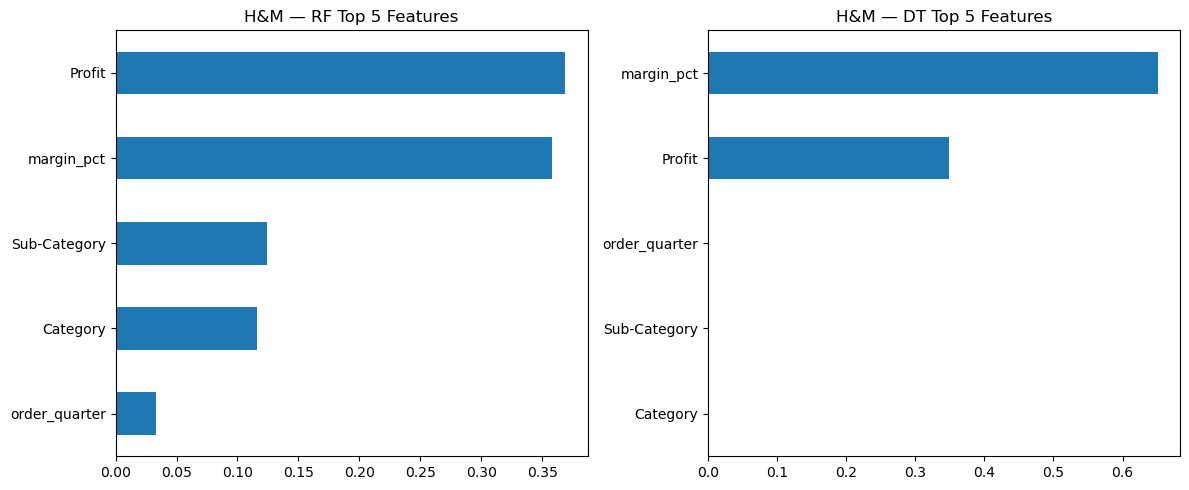

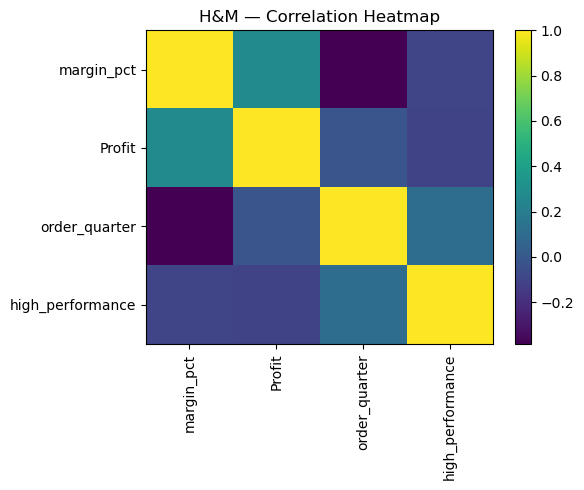

In [9]:
# ==================================== H&M ===================================================

# In the below lines of code, we are importing the required libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    average_precision_score
)
from sklearn.inspection import permutation_importance

# Loading the dataset from the local system.
file_pathway = r"C:\\Users\\ROHIT PAUL\\Desktop\\Dissertation Dataset\\H&M.xlsx"
data_01 = pd.ExcelFile(file_pathway)

# Picking up the first non-empty sheet from the Excel file.
usable_sheet = next((s for s in data_01.sheet_names if pd.read_excel(data_01, sheet_name=s).shape[0] > 0), None)
if usable_sheet is None:
    raise ValueError("No non-empty sheets found in H&M.xlsx") # This error message gets triggered if all the sheets are empty.
    
# The below line pf code loads the sheet into a DataFrame and drops the empty columns.
data_frame = pd.read_excel(data_01, sheet_name=usable_sheet).dropna(axis=1, how="all").copy()

# The below piece of code converts the columns to numbers wherever possible.
for col in ["Sales", "Quantity", "Discount", "Profit"]:
    if col in data_frame.columns:
        data_frame[col] = pd.to_numeric(data_frame[col], errors="coerce")

# Seasonal features
if "Order Date" in data_frame.columns:
    dt = pd.to_datetime(data_frame["Order Date"], errors="coerce") # This line is converting the orderdate format into datetime format.
    data_frame["order_quarter"] = dt.dt.quarter

# Pricing feature
# In the below codes, a new column is created to evaluate the profit margin% = Profit / Sales.
if {"Sales","Profit"}.issubset(data_frame.columns):
    data_frame["margin_pct"] = np.where((data_frame["Sales"]>0) & np.isfinite(data_frame["Profit"]),
                                data_frame["Profit"]/data_frame["Sales"], np.nan)
    
# Target Sales >= 75th Percentile.
if "Sales" not in data_frame.columns:
    raise ValueError("'Sales' column not found.") # An error message is raised if sales data is not found.
data_frame = data_frame.dropna(subset=["Sales"]).copy() # This code drops row with missing Sales.
q3 = data_frame["Sales"].quantile(0.75) # This code snippet evaluates the top 25%.
data_frame["high_performance"] = (data_frame["Sales"] >= q3).astype(int)
# The below snippet prints the cutoff value and the class imbalance.
print(f"H&M — High-performance threshold (Sales Q3): {q3:.2f}")
print(data_frame["high_performance"].value_counts(normalize=True).rename("Class proportion"))

# the below piece of code keeps the relevant columns which are needed for processing.
relevant = [c for c in ["Category","Sub-Category","margin_pct","Profit","order_quarter"] if c in data_frame.columns]

# Input Features.
X = data_frame[relevant].copy()
# Output Labels.
y = data_frame["high_performance"].astype(int)


# Train/test split.
# In the below snippet, we are spliting the data into train (80%) and test (20%) while keeping the class ratios similar.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Column types
numerical_columns = X_train.select_dtypes(include=[np.number]).columns.tolist() # Numerical features
categorical_columns = X_train.select_dtypes(exclude=[np.number]).columns.tolist() # Categorical features

# Preprocessing. 
preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numerical_columns), # This line of code fills the missing numerical with median.
        ("cat", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")), # This line of code fills the missing categorical values with the mist frequent one.
            ("encode", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)) # This line turns categories into numbers.
        ]), categorical_columns),
    ],
    remainder="drop"
)
feature_name_01 = list(numerical_columns) + list(categorical_columns) # A variable is created here to save feature names for future usage.

# A method has been created to build and print all the key metrics.
def report_key_metrics(model_name, y_true, y_pred, y_proba):
    accuracy  = accuracy_score(y_true, y_pred) # This line of code evaluates the overall percentage of correct predictions.
    precision = precision_score(y_true, y_pred, zero_division=0) # This line checks out of predictive positive, how many are true positives.
    recall  = recall_score(y_true, y_pred, zero_division=0) # This line checks how many true positive items did we capture.
    f1   = f1_score(y_true, y_pred, zero_division=0) # Balance between precision and recall.
    roc_auc  = roc_auc_score(y_true, y_proba)
    avg_precision   = average_precision_score(y_true, y_proba) # PR-AUC.

# The below piece of code prints the summary of the model performance.
    print(f"\n=== {model_name} — Holdout Performance ===")
    print(f"Accuracy:  {accuracy:.3f}") # This line of code prints the accuracy of the model.
    print(f"Precision: {precision:.3f}") # This code prints the precision of the model.
    print(f"Recall:    {recall:.3f}") # This line of code prints the recall value of the model.
    print(f"F1-score:  {f1:.3f}") # This line of code prints the F1 score of the model.
    print(f"ROC-AUC:   {roc_auc:.3f}") # This line of code prints the ROC-AUC value of the model.
    print(f"PR-AUC:    {avg_precision:.3f}") # This line of code prints the PR-AUC value of the model.
    print() # This inserts a blank line.
# The below piece of code displays the true/false positive/negatives.
    print("Confusion matrix (rows=true, cols=pred):")
    print(confusion_matrix(y_true, y_pred))
    print() # This inserts a blank line.
#The below code prints per-class precision/recall/F1 plus macro/weighted averages.
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=3, zero_division=0))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # This piece of code sets up the 5-fold cross validation.

# Random Forest Modelling.
# The block of code below performs pre-processing and train the model of 600 trees.
random_forest = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=600, random_state=42,
        class_weight="balanced_subsample", n_jobs=-1
    ))
])
random_forest.fit(X_train, y_train) # In this line of code, the model is trained on the training set.
y_prob_randomforest = random_forest.predict_proba(X_test)[:, 1] # This line of code predicts the probabilities on the test.
y_hat_rf  = (y_prob_randomforest >= 0.5).astype(int)
report_key_metrics("Random Forest", y_test, y_hat_rf, y_prob_randomforest)
var_cv_rf = cross_val_score(random_forest, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
print("RF — CV ROC-AUC (mean ± sd): %.3f ± %.3f" % (var_cv_rf.mean(), var_cv_rf.std()))

randomforest_fi = pd.Series(random_forest.named_steps["clf"].feature_importances_, index=feature_name_01).sort_values(ascending=False)
print("\nTop Features — RF Feature Importance Analysis")
print(randomforest_fi) # This line of code prints the feature importance analysis of the model.

# Permutation importance on holdout
# The below code evaluates feature importance by measuring performance drop when a feature is shuffled.
perm_rf = permutation_importance(random_forest, X_test, y_test, n_repeats=12, random_state=42, n_jobs=-1)
perm_rf_s = pd.Series(perm_rf.importances_mean, index=feature_name_01).sort_values(ascending=False)  # This line of code turns the result into a sorted series.
print("\nTop Features — RF Permutation Importance (Holdout)") # This line of the code prints the top features.
print(perm_rf_s)

# Building Decision Tree classifier as the benchmark model.
decision_tree = Pipeline([
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(max_depth=5, random_state=42, class_weight="balanced"))
])
decision_tree.fit(X_train, y_train) # This line trains the decision tree model.
y_prob_decision_tree = decision_tree.predict_proba(X_test)[:, 1]
y_hat_decision_tree  = (y_prob_decision_tree >= 0.5).astype(int)
report_key_metrics("Decision Tree (max_depth=5)", y_test, y_hat_decision_tree, y_prob_decision_tree) # displaying the metrics.
cv_decision_tree = cross_val_score(decision_tree, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
print("DT — CV ROC-AUC (mean ± sd): %.3f ± %.3f" % (cv_decision_tree.mean(), cv_decision_tree.std())) # This line of the code prints the CV scores.

# Feature Importance Analysis - Decision Tree Classifier.
decision_tree_fi = pd.Series(decision_tree.named_steps["clf"].feature_importances_, index=feature_name_01).sort_values(ascending=False)
print("\nTop Features — Decision Tree Feature Importance Analysis") # This line of the code prints the feature importance analysis of the DT model.
print(decision_tree_fi)


# Comparing top 5 features - RF vs DT 
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # This line of code creates 2 plots side-by-side.
randomforest_fi.head(5).iloc[::-1].plot.barh(ax=axes[0], title="H&M — RF Top 5 Features") # Random Forest top 5 features.
decision_tree_fi.head(5).iloc[::-1].plot.barh(ax=axes[1], title="H&M — DT Top 5 Features") # Decision Tree top 5 features.
plt.tight_layout(); plt.show() # Printing the plots.

# Correlation Heatmap.
correlation_df_01 = pd.concat([X_train[numerical_columns], y_train], axis=1) # In this line of the code, we combine the numeric features and the targets.
if correlation_df_01.shape[1] >= 2: 
    corr_heatmap = correlation_df_01.corr() # In this line, we are evaluating the correlation matrix.
    plt.figure(figsize=(6, 5)) # This line sets the size of the heatmap.
    im = plt.imshow(corr_heatmap, aspect="auto")
    plt.title("H&M — Correlation Heatmap") # This line adds the title of the heatmap.
    plt.xticks(range(len(corr_heatmap.columns)), corr_heatmap.columns, rotation=90) # Labelling the X-axis.
    plt.yticks(range(len(corr_heatmap.index)), corr_heatmap.index) # Labelling the Y-axis.
    plt.colorbar(im) # This line adds a color bar for reference.
    plt.tight_layout(); plt.show() # This line of the code shows the plot.
